In [2]:
import random
import numpy as np
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import random
from albumentations import (
    HorizontalFlip, RandomRotate90, Transpose, RandomBrightnessContrast,  Compose, VerticalFlip,HorizontalFlip, IAAAdditiveGaussianNoise)

In [19]:
augm = Compose([
        RandomRotate90(p=0.5),
        Transpose(p=0.5),
#         ShiftScaleRotate(shift_limit=0.0, scale_limit=0.50, rotate_limit=0, border_mode=cv2.BORDER_CONSTANT, p=.75),
        RandomBrightnessContrast(brightness_limit=0.11, contrast_limit=0.4, p=0.7),  
    VerticalFlip(p=0.7),HorizontalFlip(p=0.7), IAAAdditiveGaussianNoise(scale = [0, 0.013], p = 0.7)
        #RandomScale(scale_limit=0.3)
    ])

c:\Users\stan_\lidc-idri-preproc\diploma_work\EfficientNet\.conda\lib\site-packages\albumentations\imgaug\transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)


In [4]:
texture1 = np.load("texture1.npy")

In [6]:
texture1.shape

(34, 32, 32, 16)

In [38]:
def display_series(idata, kIm=5, fcols=3):
    frows = kIm//fcols + 1
    
    for i,idx in enumerate(range(int(8-kIm/2), int(8+kIm/2))):
        sub = plt.subplot(frows, fcols, i+1)
        sub.imshow(idata[:,:,idx], 'gray')
        print(idx)

4
5
6
7
8
9
10
11


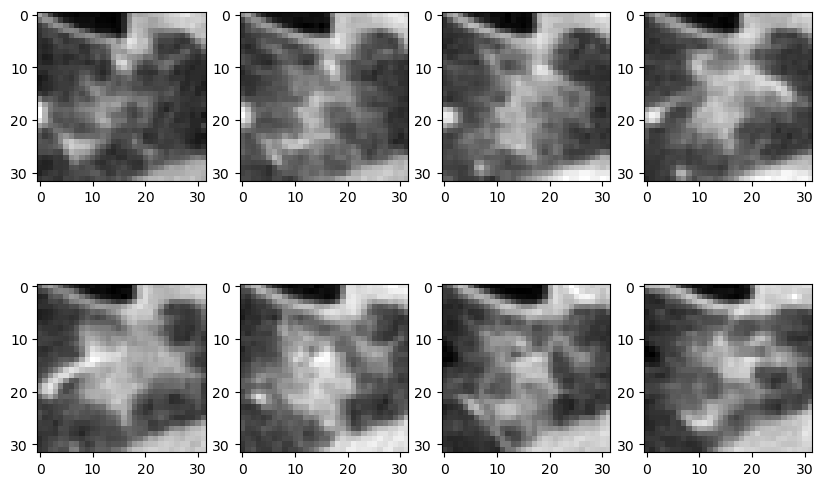

In [42]:
plt.figure(figsize=(10,10))
display_series(texture1[8, :, :], 8, 4)

4
5
6
7
8
9
10
11


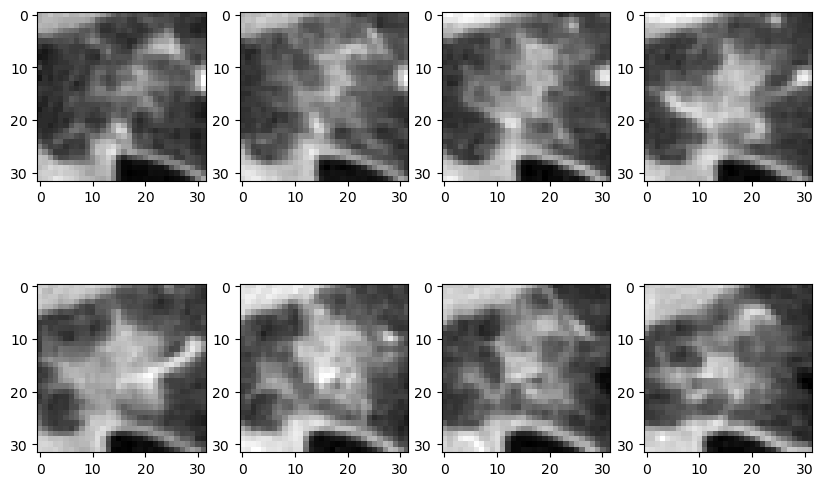

In [46]:
test_aug = augm(image = texture1[8])['image']
plt.figure(figsize=(10,10))
display_series(test_aug, 8, 4)

In [7]:
import matplotlib.pyplot as plt

In [21]:
test_aug = augm(image = texture1[8])['image']

In [52]:
small_nodules_normalize.shape

(3905, 32, 32, 16)

In [70]:
texture1 = np.load("texture1.npy")
texture2 = np.load("texture2.npy")
texture3 = np.load("texture3.npy")
texture4 = np.load("texture4.npy")
texture5 = np.load("texture5.npy")
non_nodules_normalize = np.load("non_nodules_normalize.npy")
small_nodules_normalize = np.load("small_nodules_normalize.npy")

all_textures = [texture1, texture2, texture3, texture4, texture5]

def split_data(data, exclude_part):
    test = data[int(data.shape[0]*(exclude_part - 1)/10):int(data.shape[0]*(exclude_part)/10), :, :, :]
    
    if exclude_part < 10:
        val = data[int(data.shape[0]*(exclude_part)/10):int(data.shape[0]*(exclude_part + 1)/10), :, :, :]
        
        if exclude_part > 1:
            train = np.concatenate((data[:int(data.shape[0]*(exclude_part - 1)/10), :, :, :], data[int(data.shape[0]*(exclude_part+1)/10):, :, :, :]), axis = 0)
            print(train.shape)
        else:
            train = data[int(data.shape[0]*(exclude_part + 1)/10):, :, :, :]
            print(train.shape)
        
    else:
        #от 1 до 8 - т.к 9 и 10 не могут быит валидационными
        choose_val_part = random.randint(1, 8)
        val = data[int(data.shape[0]*(choose_val_part - 1)/10):int(data.shape[0]*(choose_val_part)/10)]

        if choose_val_part > 1:
            train = np.concatenate((data[:int(data.shape[0]*(choose_val_part - 1)/10), :, :, :], data[int(data.shape[0]*(choose_val_part)/10):int(data.shape[0]*(exclude_part - 1)/10), :, :, :]), axis = 0)
        else:
            train = data[int(data.shape[0]*(choose_val_part)/10):int(data.shape[0]*(exclude_part - 1)/10), :, :, :]
    return train, test, val

def aug_data(data, texture = True):
    print('data', data.shape)
    k = 5
    if not texture: k = 1

    mult = int((non_nodules_normalize.shape[0]*0.8)/k//data.shape[0])
    print((non_nodules_normalize.shape[0]*0.8)/k)
    extra = int((non_nodules_normalize.shape[0]*0.8)/k%data.shape[0])
    res = []
    for i in data:
        res.append(i)
        
        for j in range(mult - 1):
            res.append(augm(image = i)['image'])
            
    for i in range(extra):
        ind = random.randint(0, data.shape[0]-1)
        res.append(augm(image = data[ind])['image'])
    
    res = np.array(res)
    np.random.shuffle(res)
    return res

X_train, X_val, X_test, y_train, y_val, y_test, add_train, add_test, add_val = [], [], [], [], [], [], [], [], []

for i in range(1, 11):
    for j in range(4):
        print('all_textures', all_textures[j].shape)
        train, test, val = split_data(all_textures[j], i)
        print('train', train.shape)
        trainAug = aug_data(train)
        X_train.append(trainAug)
        X_val.append(val)
        X_test.append(test)
        print(j, trainAug.shape)
        y_train.append(np.full((1, trainAug.shape[0]), 0))
        y_val.append(np.full((1, val.shape[0]), 0))
        y_test.append(np.full((1, test.shape[0]), 0))
        
        add_train.append(np.full((1, trainAug.shape[0]), j+1))
        add_val.append(np.full((1, val.shape[0]), j+1))
        add_test.append(np.full((1, test.shape[0]), j+1))

    train, test, val = split_data(texture5, i)
    
    X_train.append(train)
    X_val.append(val)
    X_test.append(test)

    y_train.append(np.full((1, train.shape[0]), 0))
    y_val.append(np.full((1, val.shape[0]), 0))
    y_test.append(np.full((1, test.shape[0]), 0))

    add_train.append(np.full((1, train.shape[0]), 5))
    add_val.append(np.full((1, val.shape[0]), 5))
    add_test.append(np.full((1, test.shape[0]), 5))


    train, test, val = split_data(small_nodules_normalize, i)
    print('train', train.shape)

    trainAug = aug_data(train)
    X_train.append(trainAug)
    X_val.append(val)
    X_test.append(test)

    y_train.append(np.full((1, trainAug.shape[0]), 1))
    y_val.append(np.full((1, val.shape[0]), 1))
    y_test.append(np.full((1, test.shape[0]), 1))

    add_train.append(np.full((1, trainAug.shape[0]), -1))
    add_val.append(np.full((1, val.shape[0]), -1))
    add_test.append(np.full((1, test.shape[0]), -1))

    train, test, val = split_data(non_nodules_normalize, i)
    
    X_train.append(train)
    X_val.append(val)
    X_test.append(test)

    y_train.append(np.full((1, train.shape[0]), 2))
    y_val.append(np.full((1, val.shape[0]), 2))
    y_test.append(np.full((1, test.shape[0]), 2))

    add_train.append(np.full((1, train.shape[0]), -1))
    add_val.append(np.full((1, val.shape[0]), -1))
    add_test.append(np.full((1, test.shape[0]), -1))


all_textures (34, 32, 32, 16)
(28, 32, 32, 16)
train (28, 32, 32, 16)
data (28, 32, 32, 16)
789.6
0 (789, 32, 32, 16)
all_textures (55, 32, 32, 16)
(44, 32, 32, 16)
train (44, 32, 32, 16)
data (44, 32, 32, 16)
789.6
1 (789, 32, 32, 16)
all_textures (50, 32, 32, 16)
(40, 32, 32, 16)
train (40, 32, 32, 16)
data (40, 32, 32, 16)
789.6
2 (789, 32, 32, 16)
all_textures (253, 32, 32, 16)
(203, 32, 32, 16)
train (203, 32, 32, 16)
data (203, 32, 32, 16)
789.6
3 (789, 32, 32, 16)
(792, 32, 32, 16)
(3124, 32, 32, 16)
train (3124, 32, 32, 16)
data (3124, 32, 32, 16)
789.6
(3948, 32, 32, 16)
all_textures (34, 32, 32, 16)
(27, 32, 32, 16)
train (27, 32, 32, 16)
data (27, 32, 32, 16)
789.6
0 (789, 32, 32, 16)
all_textures (55, 32, 32, 16)
(44, 32, 32, 16)
train (44, 32, 32, 16)
data (44, 32, 32, 16)
789.6
1 (789, 32, 32, 16)
all_textures (50, 32, 32, 16)
(40, 32, 32, 16)
train (40, 32, 32, 16)
data (40, 32, 32, 16)
789.6
2 (789, 32, 32, 16)
all_textures (253, 32, 32, 16)
(203, 32, 32, 16)
train (203

In [ ]:
def shuffl(X, y, add):
    p = np.random.permutation(X.shape[0])
    return X[p], y[:, p], add[:, p]

X_tr = []
X_vl = []
X_tst = []
y_tr = []
y_vl = []
y_tst = []
add_tr = []
add_vl = []
add_tst = []
for i in range(0, len(X_train), 7):
    tmp_x_tr  = X_train[i]
    tmp_x_vl  = X_val[i]
    tmp_x_tst = X_test[i]

    tmp_y_tr  = y_train[i]
    tmp_y_vl = y_val[i]
    tmp_y_tst = y_test[i]

    tmp_add_tr  = add_train[i]
    tmp_add_vl = add_val[i]
    tmp_add_tst = add_test[i]
    print('i',i)
    for j in range(i+1, i + 7):
        print(j)
        tmp_x_tr =  np.concatenate((tmp_x_tr,  X_train[j]), axis = 0)
        tmp_x_vl  = np.concatenate((tmp_x_vl, X_val[j]), axis = 0)
        tmp_x_tst = np.concatenate((tmp_x_tst, X_test[j]), axis = 0)
        print(tmp_y_tst.shape)
        tmp_y_tr  = np.concatenate((tmp_y_tr,   y_train[j]), axis = 1)
        tmp_y_vl  = np.concatenate((tmp_y_vl , y_val[j]), axis = 1)
        tmp_y_tst = np.concatenate((tmp_y_tst, y_test[j]), axis = 1)

        tmp_add_tr  = np.concatenate((tmp_add_tr ,  add_train[j]), axis = 1)
        tmp_add_vl  = np.concatenate((tmp_add_vl , add_val[j]), axis = 1)
        tmp_add_tst = np.concatenate((tmp_add_tst, add_test[j]), axis = 1)
        
    tmp_x_tr, tmp_y_tr, tmp_add_tr     = shuffl(tmp_x_tr, tmp_y_tr, tmp_add_tr   )
    tmp_x_vl, tmp_y_vl, tmp_add_vl   =   shuffl(tmp_x_vl, tmp_y_vl, tmp_add_vl   )
    tmp_x_tst, tmp_y_tst, tmp_add_tst  = shuffl(tmp_x_tst, tmp_y_tst, tmp_add_tst)
    
    np.save("for3D/X_tr" + str(i//7 + 1), tmp_x_tr )
    np.save("for3DX_vl" + str(i//7 + 1), tmp_x_vl )
    np.save("/for3DX_tst" + str(i//7 + 1),tmp_x_tst)

    np.save("for3D/y_tr" + str(i//7 + 1), tmp_y_tr )
    np.save("for3D/y_vl" + str(i//7 + 1), tmp_y_vl )
    np.save("for3D/y_tst" + str(i//7 + 1),tmp_y_tst)

    np.save("for3D/add_tr" + str(i//7 + 1), tmp_add_tr )
    np.save("for3D/add_vl" + str(i//7 + 1), tmp_add_vl )
    np.save("for3D/add_tst" + str(i//7 + 1),tmp_add_tst)

In [3]:
p = np.load("for3D/X_tr2.npy")
p.shape

(11809, 32, 32, 16)